# Calibrate and triangulate data from multiple Sleap networks

(latest version on Github at https://github.com/tytell/tytell-lab.git)
This file from commit $Id$

Reequires (`sleap`)[https://sleap.ai/index.html] and `aniposelib` (version 0.6.1 or higher). Follow the directions to set up Sleap. Then  install `aniposelib` in the same python environment as Sleap: 
> % conda activate sleap

> % python -m pip install aniposelib

In [1]:
import os
import aniposelib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

Skip down to the Sleap section if you've already done the calibration and have the `.toml` file.

Set up to detect a CHaRuCO board. Make sure you identify the number of squares and their size in mm. The numbers below should be correct for the board we have in the lab.

`marker_length`, `marker_bits`, and `dict_size` are particular to the sort of CHaRuCO board that we have in the lab. Don't change them unless you know what you're doing.

In [2]:
board = aniposelib.boards.CharucoBoard(squaresX=6, squaresY=6,
                                        square_length=24.33, marker_length=17, marker_bits=5, dict_size=50)

Fill in the path and the names of video files that have the CHaRuCO images. For paths on Windows machines, be careful not to remove the `r` at the beginning of the quote; without it, all backslashes will be registered as special characters.

In [5]:
videopath = r'Raw data'
videonames = ['9.5.22Calib-camA.mp4', '9.5.22Calib-camB.mp4', '9.5.22Calib-camC.mp4']

This will detect points in the first video, just for testing purposes.

In [6]:
video1 = os.path.join(videopath, videonames[0])
rows = board.detect_video(video1, progress=True)

100%|█████████████████████████████| 1686/1686 [00:22<00:00, 76.17it/s]


This is how many frames were detected.

In [7]:
len(rows)

1657

## Check detected corners

This will load in a frame from the video and show the detected corners.

In [8]:
cap = cv2.VideoCapture(video1)

You can change `i` to look at a different frame

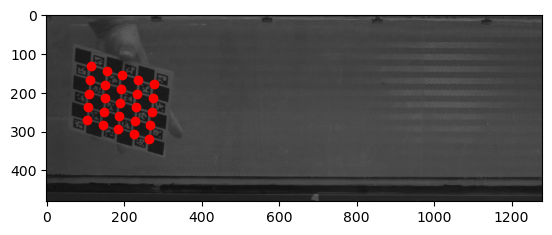

In [9]:
i = 100
fr = rows[i]['framenum']

cap.set(1, fr)
ret, frame = cap.read()

fig, ax = plt.subplots()
ax.imshow(frame)
ax.plot(rows[i]['corners'][:,0,0], rows[i]['corners'][:,0,1], 'ro')

Don't forget to run the code block below to close the video file.

In [10]:
cap.release()

## Calibrate based on all the videos

This will run through all of the videos and detect the corners, then do the calibration and save it out as a `.toml` file

In [59]:
vidnames = [[os.path.join(videopath, fn)] for fn in videonames]
camnames = ['camA', 'camB', 'camC']
ncams = len(vidnames)

camgroup = aniposelib.cameras.CameraGroup.from_names(camnames)

Run the `aniposelib` functions to calibrate based on the videos, and save out the calibration.

In [60]:
camgroup.calibrate_videos(vidnames, board)
camgroup.dump('calibration.toml')

Raw data/9.5.22Calib-camA.mp4


100%|█████████████████████████████| 1686/1686 [00:24<00:00, 69.10it/s]


1657 boards detected
Raw data/9.5.22Calib-camB.mp4


100%|█████████████████████████████| 1686/1686 [01:03<00:00, 26.66it/s]


1676 boards detected
Raw data/9.5.22Calib-camC.mp4


100%|█████████████████████████████| 1686/1686 [00:42<00:00, 39.90it/s]


1683 boards detected
[{'name': 'camA', 'size': [1280, 480], 'matrix': [[4668.769373336774, 0.0, 639.5], [0.0, 4668.769373336774, 239.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'camB', 'size': [2048, 1200], 'matrix': [[4754.5054600307385, 0.0, 1023.5], [0.0, 4754.5054600307385, 599.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'camC', 'size': [1920, 800], 'matrix': [[3396.0631243647967, 0.0, 959.5], [0.0, 3396.0631243647967, 399.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('camA', 'camB'): 1643,
             ('camA', 'camC'): 1652,
             ('camB', 'camA'): 1643,
             ('camB', 'camC'): 1670,
             ('camC', 'camA'): 1652,
             ('camC', 'camB'): 1670})
error:  3.6

# Load in the Sleap data files

In [61]:
from sleap.io.dataset import Labels

Load the calibration we did above. Make sure the file name is correct!

In [72]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

Fill in the names of your cameras and the names of the Sleap `.slp` data files. You should have the same number of Sleap files as you do cameras. But if you trained the same network for multiple views, just repeat the name of the `.slp` file.

Note that the videos need to have matching names across the cameras. So you should have something like:
* test1_camA.mp4, test1_camB.mp4, test1_camC.mp4

or

* camA_test1.mp4, camB_test1.mp4, camC_test1.mp4

or something like that.

In [73]:
camnames = ["camA", "camB", "camC"]

sleapfiles = ["Raw data/SeparateCameras/CamA/BigSLEAPturningTraining-camA.slp",
            "Raw data/SeparateCameras/CamB&C/BigSLEAPturningTraining-camB&C.slp",
            "Raw data/SeparateCameras/CamB&C/BigSLEAPturningTraining-camB&C.slp"]

Load in the Sleap data files

In [74]:
labels = [Labels.load_file(fn) for fn in sleapfiles]

node_count = len(labels[0].skeletons[0].nodes)
node_names = [node.name for node in labels[0].skeletons[0].nodes]

videos = [[v1.backend.filename for v1 in l1.videos if re.search(c1, v1.backend.filename) is not None] for l1, c1 in zip(labels, camnames)]

Function to separate the name of a video and the camera names, so that we can match up videos for different cameras.

In [75]:
def separate_video_and_camera(vidname, camnames):
    fn1 = re.sub(r'\\', '/', vidname)
    fn1 = os.path.basename(fn1)

    for cam1 in camnames:
        fn1, nsub = re.subn(cam1, 'CAMERA', fn1)
        if nsub == 1:
            matched_camera = cam1
            break
    else:
        matched_camera = None

    return fn1, matched_camera

Pull out the $x$ and $y$ coordinates from the Sleap data files and match the same point in the same frame across cameras.

In [76]:
nodenames = [n.name for n in labels[0].skeletons[0].nodes]

ptsall = []
for l1, cam1 in zip(labels, camnames):
    pts = []
    for v1 in l1.videos:
        vidname1, camname1 = separate_video_and_camera(v1.backend.filename, camnames)
        if camname1 != cam1:
            continue
        
        frames = l1.get(v1)
        frame_idx = [lf.frame_idx for lf in frames]

        col_ind = pd.MultiIndex.from_product([[camname1], ['x', 'y']],
                                             names = ['camera', 'point'])
        row_ind = pd.MultiIndex.from_product([[vidname1], frame_idx, nodenames], 
                                             names = ['video', 'frame', 'node'])

        pts1 = pd.DataFrame(index = row_ind, columns=col_ind)

        for lf in frames:
            if len(lf.user_instances) == 1:
                inst = lf.user_instances[0]
            elif len(lf.predicted_instances) == 1:
                inst = lf.predicted_instances[0]
            else:
                print("Error!")
                assert(False)
            
            pts1.loc[(vidname1, lf.frame_idx, slice(None)), (camname1, slice(None))] = inst.numpy()

        pts.append(pts1)
    
    ptsall.append(pd.concat(pts, axis=0))

ptsall = pd.concat(ptsall, axis=1)

In [77]:
ptsall.head()

camera                                                          camA  \
point                                                              x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

camera                                                           camB  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

camera                                                           camC  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

camera                                                                
point                                                              y  
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818  
                                          GillCenterLow       404.17  
                                          PelvFinsCenter  400.452633  
                                          MidPelvAnal     404.822813  
                                          AnalBase        395.610202

Reshape the DataFrame into a 3D numpy matrix. Should have shape $C \times N \times 2$, where $C$ is the number of cameras, $N$ is the number of points, and 2 is for $x$ and $y$ coordinates.

In [78]:
ptsmatrix = ptsall.to_numpy().reshape((-1, 3, 2))
ptsmatrix = ptsmatrix.transpose((1,0,2)).astype(np.float64)
print(ptsmatrix.shape)

(3, 2898, 2)


Show the first point in each camera so that we can compare to the DataFrame above. Should have x and y in the columns and cameras in the rows.

In [79]:
ptsmatrix[:,0,:]

array([[ 707.526168,  194.342777],
       [1252.28    ,  498.26    ],
       [1025.193042,  416.56818 ]])

Triangulate the points to 3D. NB - it's important to do the undistortion. Without it, we get *terrible* reprojection errors.

In [84]:
pts3d = camgroup.triangulate(ptsmatrix, progress=True, undistort=True)

100%|███████████████████████████| 2898/2898 [00:00<00:00, 3160.87it/s]


...and compute the reprojection error.

In [87]:
reproj_err = camgroup.reprojection_error(pts3d, ptsmatrix, mean=False)
errors_norm = np.linalg.norm(reproj_err, axis=2)

In [89]:
errors_norm[:,0:5]

array([[ 1.64181236,  0.13271276,  3.65026169, 18.65553875,  2.20775309],
       [ 5.93548518,  3.62771793,  1.84589279, 13.74086141,  4.34290471],
       [ 4.56340915,  2.91243791,  5.12464421, 38.23958076,  4.28177898]])

Now build up the same DataFrame as the original points so that we can merge them all.

First for the 3D points themselves

In [90]:
col_ind = pd.MultiIndex.from_product([['3D'], ['x', 'y', 'z']],
                                        names = ['camera', 'point'])

pts3d = pd.DataFrame(pts3d, index=ptsall.index, columns=col_ind)

...and then for the reprojection error. The original reprojection error gives us errors in both $x$ and $y$, but we're just interested in the distance, so we use `np.linalg.norm` to get the distance and then merge it into a DataFrame

In [91]:
col_ind = pd.MultiIndex.from_product([camnames, ['reproj_err']],
                                        names = ['camera', 'point'])

errors_norm = pd.DataFrame(errors_norm.T, index=ptsall.index, columns=col_ind)

These are the median reprojection errors. Make sure they're not too big.

In [96]:
errors_norm.groupby(level=2).median()

camera,camA,camB,camC
point,reproj_err,reproj_err,reproj_err
node,,,
AnalBase,1.814322,3.388087,3.656112
GillCenterLow,1.709694,3.608193,4.477043
MidAnalBasePeduncle,2.348747,4.137937,3.612683
MidPelvAnal,1.876800,4.579147,5.341671
Peduncle,1.716898,3.055638,3.840764
PelvFinsCenter,1.824842,3.762363,3.589790
Snout,1.217164,3.498780,3.500920


Then we merge all of the data frames so that we have the 2D x and y coordinates and the 3D coordinates with reprojection errors.

In [97]:
ptsall3d = pd.concat((ptsall, errors_norm, pts3d), axis=1)
ptsall3d.head()

camera                                                          camA  \
point                                                              x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

camera                                                           camB  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

camera                                                           camC  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818   
                                          GillCenterLow       404.17   
                                          PelvFinsCenter  400.452633   
                                          MidPelvAnal     404.822813   
                                          AnalBase        395.610202   

camera                                                         camA  \
point                                                    reproj_err   
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            1.641812   
                                          GillCenterLow    0.132713   
                                          PelvFinsCenter   3.650262   
                                          MidPelvAnal     18.655539   
                         

And then rearrange the MultiIndexes so that we can save it in a simple CSV format easily.

In [98]:
ptsall3d.columns = ['_'.join(reversed(c)) for c in ptsall3d.columns.to_flat_index()]
ptsall3d.reset_index(inplace=True)
ptsall3d.head()

,video,frame,node,x_camA,y_camA,x_camB,y_camB,x_camC,y_camC,reproj_err_camA,reproj_err_camB,reproj_err_camC,x_3D,y_3D,z_3D
0,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,Snout,707.526168,194.342777,1252.28,498.26,1025.193042,416.56818,1.641812,5.935485,4.563409,34.748052,-28.498434,2678.066787
1,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,GillCenterLow,748.02,222.92,1340.9,491.06,1103.15,404.17,0.132713,3.627718,2.912438,59.607126,-12.362643,2676.565401
2,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,PelvFinsCenter,781.178769,227.122296,1398.11,491.36,1141.59631,400.452633,3.650262,1.845893,5.124644,76.799889,-11.202936,2676.509811
3,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,MidPelvAnal,807.950671,225.924293,1435.700043,483.431097,1122.599477,404.822813,18.655539,13.740861,38.239581,84.681405,-16.646453,2675.583726
4,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,AnalBase,818.053275,225.924293,1471.253292,481.959874,1196.597994,395.610202,2.207753,4.342905,4.281779,98.795418,-12.147626,2674.989351


And save! Remember to adjust the file name as needed.

In [99]:
ptsall3d.to_csv('points3d.csv', index=False)